In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_test_models/SimpleRNN_test_model.h5')

2023-08-24 11:19:54.818901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 11:19:54.848261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 11:19:54.848826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 11:19:55.454729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-24 11:19:56.081534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 11:19:56.081866: W tensorflow/core/common_r

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm
from scipy.linalg import fractional_matrix_power

# pauli matrix
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])

# Detunning Factor
d0 = 0.15
v0 = 0.02

def Rx(theta):
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])

def Rz(phi): # Rz는 사용하지 않음. 해밀토니안에 의한 회전으로만 컨트롤
    return np.matrix([[cos(phi/2)-1j*sin(phi/2),       0],
                     [0,                          cos(phi/2)+1j*sin(phi/2)]])

def unitary(dt, choice) :
    choice_list = [0,1,-1,1,-1] # x,y-rotiation 방향 선택
    if choice <3 :
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else :
        Ham = (d0*sz+v0*choice_list[choice]*sy)
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    return U_e

def state_fidelity(rho_1, rho_2): 
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)




init_wave = np.array([[1],[0]])
irho_init = np.kron(init_wave,init_wave.conj().T)

def fidelity(target_theta,target_phi) :
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @target_U.conj().T

    # 모델로 예측
    new_theta = np.array(target_theta).reshape(-1,1)
    new_phi = np.array(target_phi).reshape(-1,1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    # 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)


    Uni = s0
    U_0 = unitary(2.6,0)
    U_1 = unitary(2.6,1)
    U_2 = unitary(2.6,2)
    U_3 = unitary(2.6,3)
    U_4 = unitary(2.6,4)
    pulse_list = [U_0,U_1,U_2,U_3,U_4]
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     # 새로운 theta와 phi 값 정의
     #target_theta = np.pi/180*random.uniform(0,180)  # 예시 값
     target_theta = np.pi/180*random.uniform(0,180)
     target_phi = np.pi/180*random.uniform(0,360)   # 예시 값
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     sum += temp
print(sum/iter)

1/1 [==============================] - 0s 19ms/step
0.9900218558441024


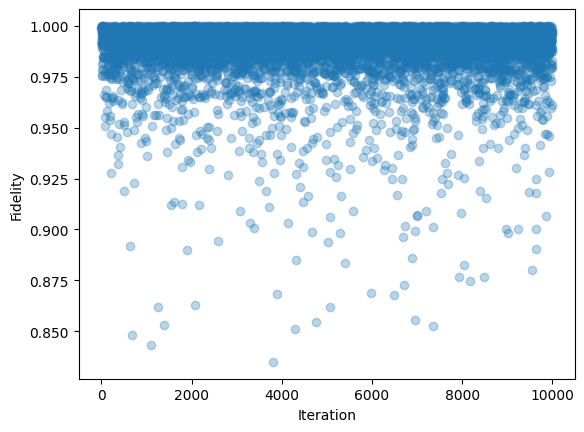

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

8 0.9781715872377614
16 0.9810647582775438
17 0.975520794776815
23 0.975789387352376
26 0.9890391837948153
31 0.9845222077019439
33 0.9821026351363005
41 0.9881561643302262
44 0.9790064323792447
46 0.9841790737878164
49 0.985270794540566
61 0.9847592135805597
68 0.9658441240207372
72 0.987355492647648
75 0.9769598869019013
79 0.9550568749703175
81 0.9507389526560429
87 0.9844411076832628
90 0.9854385482406389
93 0.9755789618746535
98 0.9650839442375229
101 0.9789836157382573
106 0.9683291514566477
111 0.9649808512613811
113 0.9899405262212935
118 0.9848728927894703
124 0.9582070209445395
138 0.9791726551430234
140 0.9853044081043305
143 0.9807935006808466
149 0.9833143059327015
155 0.9882929073860947
158 0.9896690738240421
159 0.9764701683785134
161 0.9622886597105743
164 0.9893734336943679
171 0.9837033999940505
173 0.9810383230399147
176 0.975199533252817
177 0.9837564088547585
183 0.9861640734894438
184 0.9765530085022746
186 0.9894796614410374
188 0.9742696890425724
190 0.955965529

In [6]:
print(low_fidelities)
print(low_fidelities['theta'])

{'theta': [1.878978446352143, 1.7904114466471495, 0.8668105721436056, 1.353875874243802, 0.8436647493906003, 1.4232201042712336, 1.4245742330810485, 1.0321993053135559, 1.137038192533114, 1.6747978056073838, 2.487372744954362, 2.7757778043251995, 1.9033121137275182, 2.9537009261725387, 2.195804512399794, 1.9209818244868202, 1.4490425639743683, 1.5612704341480463, 0.3407321917169954, 2.285734442774673, 2.527782311787177, 1.7555386513007099, 1.9394894045795248, 1.9725702670039629, 2.9280844488708873, 1.8496859020598286, 2.485412424311036, 2.381167404182663, 1.7512023243289832, 1.807347065867424, 1.4324319939356787, 0.49831559428267014, 1.1226332000480157, 2.6007940659330533, 2.2159664013751352, 0.2867589255291231, 2.814118737371143, 1.395002863030934, 1.6778590139254452, 1.0061066453547465, 1.515828253525223, 1.3519825545090012, 1.4814227836889418, 1.3330134092228711, 1.6869348142245342, 2.8050430579780476, 2.785008278845396, 0.5698692185557825, 2.7827235625716007, 1.4642357394497718, 0.

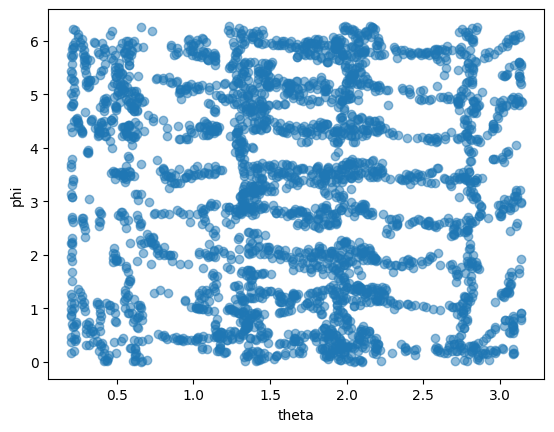

In [7]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

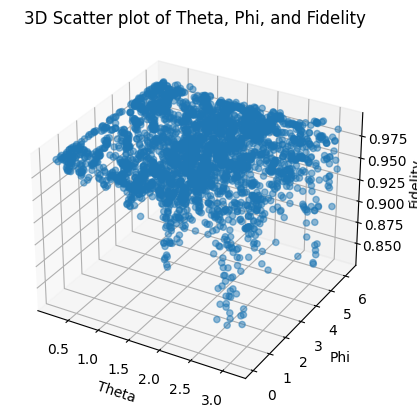

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()     
